In [1]:
import numpy as np
import pandas as pd
pd.options.display.max_columns = 500
import matplotlib.pyplot as plt
#matplotlib inline
import seaborn as sns

import warnings
warnings.simplefilter("ignore")

import sklearn

import catboost as cb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import r2_score
from typing import List, Tuple

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

from sklearn.inspection import permutation_importance
from boostaroota import BoostARoota
import shap

In [2]:
# путь расположения выборки
path_train = '/home/tefi/Homework/Sport/assignment_2_train.csv'
path_test = '/home/tefi/Homework/Sport/assignment_2_test.csv'
# загрузка данных из файла
train = pd.read_csv(path_train)
test = pd.read_csv(path_test)

train = train[0:50000]
test = test[0:50000]


train_target = train.copy()
train_target = train['isFraud']                # целевая переменная для тренировочных данных
train_target.head(3)
train_data = train.copy()
train_data = train_data.drop(['isFraud'], axis = 'columns')
test_target = test.copy()
test_target = test['isFraud']                # целевая переменная для тренировочных данных
test_data = test.copy()
test_data = test_data.drop(['isFraud'], axis = 'columns')

In [3]:
f = train_data.select_dtypes(include = ['float64', 'int64']).columns
for i in f:
    train_data.loc[(train_data[i].isnull(), [i])] = train_data[i].median()

cat = train_data.select_dtypes(include = ['object']).columns
for i in cat:
    train_data.loc[(train_data[i].isnull(), [i])] = train_data[i].mode()[0]

In [4]:
f = test_data.select_dtypes(include = ['float64', 'int64']).columns
for i in f:
    test_data.loc[(test_data[i].isnull(), [i])] = test_data[i].median()

cat = test_data.select_dtypes(include = ['object']).columns
for i in cat:
    test_data.loc[(test_data[i].isnull(), [i])] = test_data[i].mode()[0]

In [5]:
train_data

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000.0,86400.0,68.500,W,13926.0,369.0,150.0,discover,142.0,credit,315.0,87.0,19.0,30.0,gmail.com,gmail.com,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,106.0,13.0,32.0,11.0,0.0,0.0,66.875,0.666666,13.0,13.0,0.0,0.0,0.0,0.0,T,T,T,M2,F,T,F,F,T,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,117.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,117.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2987001.0,86401.0,29.000,W,2755.0,404.0,150.0,mastercard,102.0,credit,325.0,87.0,9.0,30.0,gmail.com,gmail.com,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,106.0,8.0,0.0,11.0,0.0,0.0,66.875,0.666666,0.0,30.0,0.0,0.0,0.0,0.0,T,T,T,M0,T,T,F,F,T,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0

In [6]:
x_train, x_valid, y_train, y_valid = train_test_split(train_data, train_target, test_size=0.30)

cat = train_data.select_dtypes(include = ['object']).columns

cb_params = {
    "n_estimators": 600,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": 10,
    "max_depth": 6,
    "l2_leaf_reg": 100,
    "early_stopping_rounds": 50,
    "thread_count": 6,
    "random_seed": 42
}

model = cb.CatBoostClassifier(**cb_params)
model.fit(X = x_train, y = y_train, eval_set=[(x_valid, y_valid)], cat_features=cat)

# bestTest = 0.8816399332

0:	test: 0.5634618	best: 0.5634618 (0)	total: 163ms	remaining: 1m 37s
10:	test: 0.7246879	best: 0.7246879 (10)	total: 1s	remaining: 53.6s
20:	test: 0.7908302	best: 0.7922697 (19)	total: 1.83s	remaining: 50.5s
30:	test: 0.8243970	best: 0.8243970 (30)	total: 2.69s	remaining: 49.4s
40:	test: 0.8317099	best: 0.8318170 (37)	total: 3.52s	remaining: 48s
50:	test: 0.8405905	best: 0.8405905 (50)	total: 4.37s	remaining: 47s
60:	test: 0.8481776	best: 0.8481776 (60)	total: 5.2s	remaining: 45.9s
70:	test: 0.8549528	best: 0.8549528 (70)	total: 6.04s	remaining: 45s
80:	test: 0.8562796	best: 0.8562796 (80)	total: 6.88s	remaining: 44.1s
90:	test: 0.8593772	best: 0.8593772 (90)	total: 7.71s	remaining: 43.1s
100:	test: 0.8617265	best: 0.8617265 (100)	total: 8.6s	remaining: 42.5s
110:	test: 0.8639584	best: 0.8639584 (110)	total: 9.46s	remaining: 41.7s
120:	test: 0.8658777	best: 0.8658777 (120)	total: 10.3s	remaining: 40.8s
130:	test: 0.8677350	best: 0.8677350 (130)	total: 11.1s	remaining: 39.8s
140:	test:

In [7]:
train_score = roc_auc_score(y_train, model.predict(x_train, prediction_type = "Probability")[:,1])
valid_score = roc_auc_score(y_valid, model.predict(x_valid, prediction_type = "Probability")[:,1])
test_score = roc_auc_score(test_target, model.predict(test_data, prediction_type = "Probability")[:,1])

print(f"Train-score: {round(train_score, 3)}, Valid-score: {round(valid_score, 3)}, Test-score: {round(test_score, 3)}")

# Train-score: 0.89, Valid-score: 0.882, Test-score: 0.829

Train-score: 0.89, Valid-score: 0.882, Test-score: 0.829


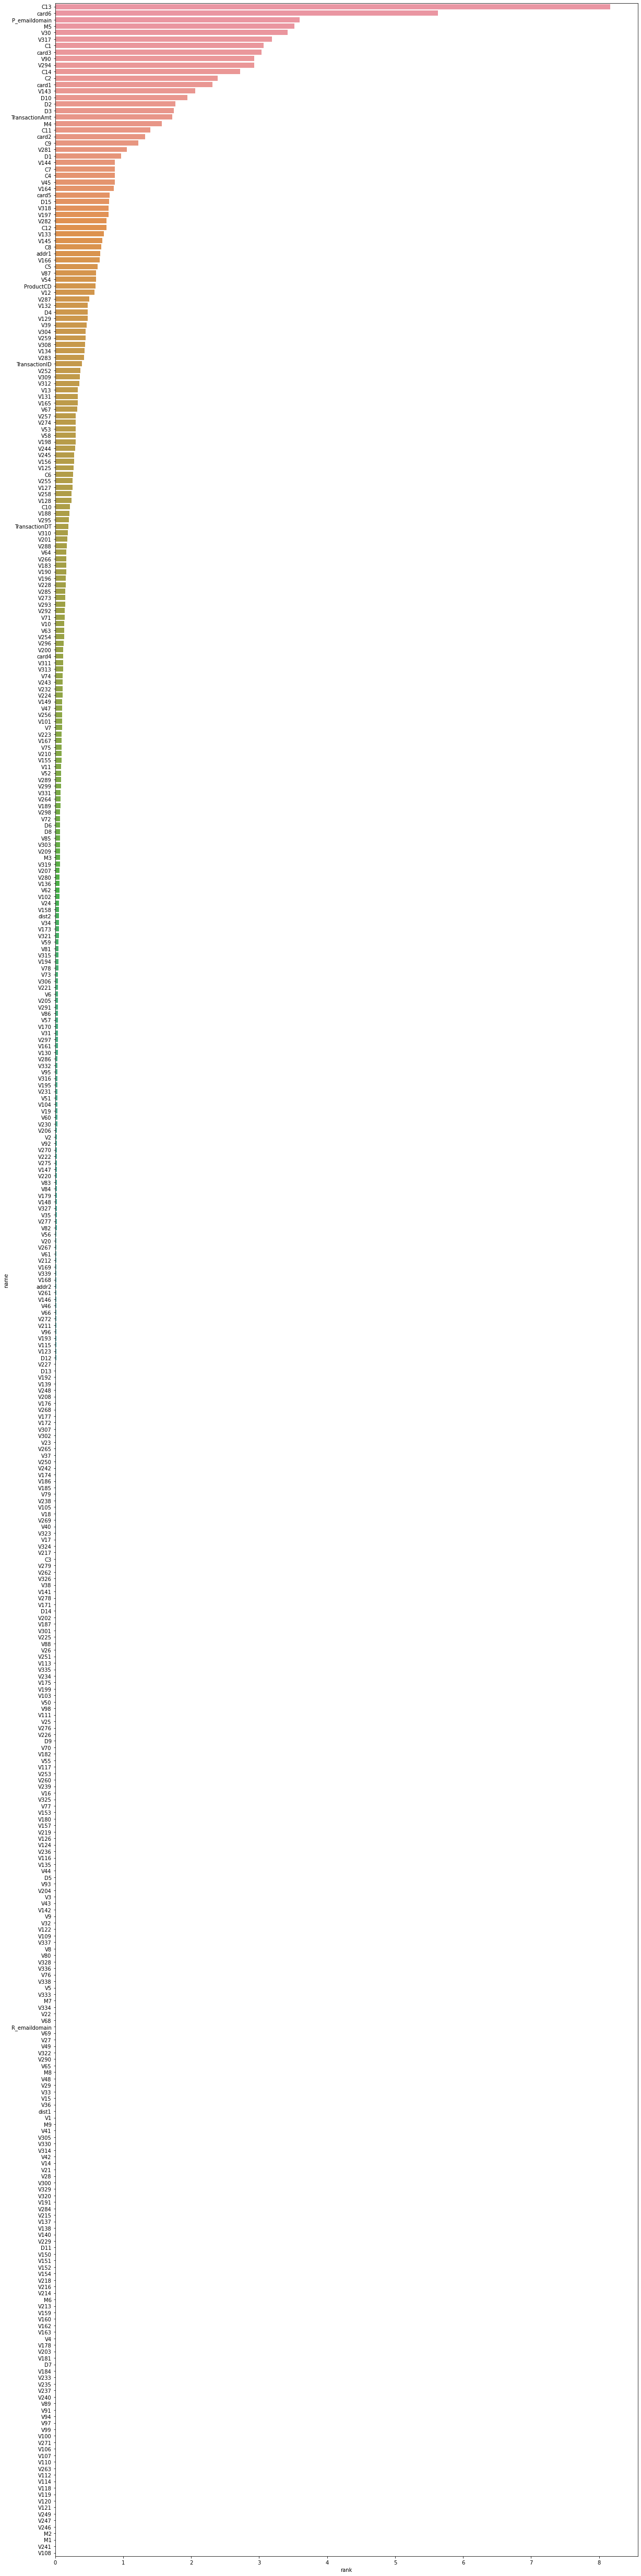

In [8]:
rank_feature_importances_ = model.feature_importances_

train_feature_importances = pd.DataFrame(rank_feature_importances_, train_data.columns)
train_feature_importances.reset_index(inplace=True)
train_feature_importances = train_feature_importances.rename(columns={'index': 'name', 0: 'rank'}) 
train_feature_importances.sort_values(by="rank", inplace=True, ascending = False)

plt.figure(figsize = ([20,90]))
sns.barplot(train_feature_importances['rank'], train_feature_importances['name'])

In [9]:
train_data

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000.0,86400.0,68.500,W,13926.0,369.0,150.0,discover,142.0,credit,315.0,87.0,19.0,30.0,gmail.com,gmail.com,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,106.0,13.0,32.0,11.0,0.0,0.0,66.875,0.666666,13.0,13.0,0.0,0.0,0.0,0.0,T,T,T,M2,F,T,F,F,T,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,117.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,117.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2987001.0,86401.0,29.000,W,2755.0,404.0,150.0,mastercard,102.0,credit,325.0,87.0,9.0,30.0,gmail.com,gmail.com,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,106.0,8.0,0.0,11.0,0.0,0.0,66.875,0.666666,0.0,30.0,0.0,0.0,0.0,0.0,T,T,T,M0,T,T,F,F,T,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0

In [10]:
features_no_imp = list(train_feature_importances['name'].tail(200))
features_no_imp

['V212',
 'V169',
 'V339',
 'V168',
 'addr2',
 'V261',
 'V146',
 'V46',
 'V66',
 'V272',
 'V211',
 'V96',
 'V193',
 'V115',
 'V123',
 'D12',
 'V227',
 'D13',
 'V192',
 'V139',
 'V248',
 'V208',
 'V176',
 'V268',
 'V177',
 'V172',
 'V307',
 'V302',
 'V23',
 'V265',
 'V37',
 'V250',
 'V242',
 'V174',
 'V186',
 'V185',
 'V79',
 'V238',
 'V105',
 'V18',
 'V269',
 'V40',
 'V323',
 'V17',
 'V324',
 'V217',
 'C3',
 'V279',
 'V262',
 'V326',
 'V38',
 'V141',
 'V278',
 'V171',
 'D14',
 'V202',
 'V187',
 'V301',
 'V225',
 'V88',
 'V26',
 'V251',
 'V113',
 'V335',
 'V234',
 'V175',
 'V199',
 'V103',
 'V50',
 'V98',
 'V111',
 'V25',
 'V276',
 'V226',
 'D9',
 'V70',
 'V182',
 'V55',
 'V117',
 'V253',
 'V260',
 'V239',
 'V16',
 'V325',
 'V77',
 'V153',
 'V180',
 'V157',
 'V219',
 'V126',
 'V124',
 'V236',
 'V116',
 'V135',
 'V44',
 'D5',
 'V93',
 'V204',
 'V3',
 'V43',
 'V142',
 'V9',
 'V32',
 'V122',
 'V109',
 'V337',
 'V8',
 'V80',
 'V328',
 'V336',
 'V76',
 'V338',
 'V5',
 'V333',
 'M7',
 'V334',

In [11]:
train_data_1 = train_data.drop(features_no_imp, axis = 'columns')
test_data_1 = test_data.drop(features_no_imp, axis = 'columns')
train_data_1

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,dist2,P_emaildomain,C1,C2,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D6,D8,D10,D15,M3,M4,M5,V2,V6,V7,V10,V11,V12,V13,V19,V20,V24,V30,V31,V34,V35,V39,V45,V47,V51,V52,V53,V54,V56,V57,V58,V59,V60,V61,V62,V63,V64,V67,V71,V72,V73,V74,V75,V78,V81,V82,V83,V84,V85,V86,V87,V90,V92,V95,V101,V102,V104,V125,V127,V128,V129,V130,V131,V132,V133,V134,V136,V143,V144,V145,V147,V148,V149,V155,V156,V158,V161,V164,V165,V166,V167,V170,V173,V179,V183,V188,V189,V190,V194,V195,V196,V197,V198,V200,V201,V205,V206,V207,V209,V210,V220,V221,V222,V223,V224,V228,V230,V231,V232,V243,V244,V245,V252,V254,V255,V256,V257,V258,V259,V264,V266,V267,V270,V273,V274,V275,V277,V280,V281,V282,V283,V285,V286,V287,V288,V289,V291,V292,V293,V294,V295,V296,V297,V298,V299,V303,V304,V306,V308,V309,V310,V311,V312,V313,V315,V316,V317,V318,V319,V321,V327,V331,V332
0,2987000.0,86400.0,68.500,W,13926.0,369.0,150.0,discover,142.0,credit,315.0,30.0,gmail.com,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,106.0,13.0,32.0,0.0,66.875,13.0,0.0,T,M2,F,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.000000,0.000000,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,117.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
1,2987001.0,86401.0,29.000,W,2755.0,404.0,150.0,mastercard,102.0,credit,325.0,30.0,gmail.com,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,106.0,8.0,0.0,0.0,66.875,0.0,0.0,T,M0,T,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.000000,0.000000,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
2,2987002.0,86469.0,59.000,W,4663.0,490.0,150.0,visa,166.0,debit,330.0,30.0,outlook.com,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,106.0,8.0,0.0,0.0,66.875,0.0,315.0,T,M0,F,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.000000,0.000000,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
3,2987003.0,86499.0,50.000,W,18132.0,567.0,150.0,mastercard,117.0,debit,476.0,30.0,yahoo.com,2.0,5.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,66.875,84.0,111.0,T,M0,T,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,38.0,0.0,1.0,1758.0,925.0,0.0,354.0,135.0,50.0,1404.0,790.0,0.

In [12]:
cat

Index(['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1',
       'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9'],
      dtype='object')

In [13]:
x_train, x_valid, y_train, y_valid = train_test_split(train_data_1, train_target, test_size=0.30)

cat = train_data_1.select_dtypes(include = ['object']).columns

cb_params = {
    "n_estimators": 600,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": 10,
    "max_depth": 6,
    "l2_leaf_reg": 100,
    "early_stopping_rounds": 50,
    "thread_count": 6,
    "random_seed": 42
}

model = cb.CatBoostClassifier(**cb_params)
model.fit(X = x_train, y = y_train, eval_set=[(x_valid, y_valid)], cat_features=cat)

# bestTest = 0.8816399332
# bestTest = 0.880192935 - изменение качества в третьей цифре

0:	test: 0.6924972	best: 0.6924972 (0)	total: 83.8ms	remaining: 50.2s
10:	test: 0.7794661	best: 0.7794661 (10)	total: 812ms	remaining: 43.5s
20:	test: 0.7995105	best: 0.7995105 (20)	total: 1.48s	remaining: 40.7s
30:	test: 0.8196906	best: 0.8200387 (29)	total: 2.14s	remaining: 39.2s
40:	test: 0.8347100	best: 0.8347100 (40)	total: 3.21s	remaining: 43.7s
50:	test: 0.8449854	best: 0.8449854 (50)	total: 3.99s	remaining: 42.9s
60:	test: 0.8489523	best: 0.8489523 (60)	total: 4.83s	remaining: 42.7s
70:	test: 0.8517060	best: 0.8517060 (70)	total: 5.73s	remaining: 42.7s
80:	test: 0.8540591	best: 0.8541632 (77)	total: 7.3s	remaining: 46.8s
90:	test: 0.8542982	best: 0.8547098 (87)	total: 7.99s	remaining: 44.7s
100:	test: 0.8550643	best: 0.8552688 (99)	total: 8.67s	remaining: 42.9s
110:	test: 0.8556866	best: 0.8556866 (110)	total: 9.55s	remaining: 42.1s
120:	test: 0.8569902	best: 0.8569902 (120)	total: 10.4s	remaining: 41s
130:	test: 0.8575658	best: 0.8575658 (130)	total: 11.1s	remaining: 39.8s
140

In [14]:
train_score = roc_auc_score(y_train, model.predict(x_train, prediction_type = "Probability")[:,1])
valid_score = roc_auc_score(y_valid, model.predict(x_valid, prediction_type = "Probability")[:,1])
test_score = roc_auc_score(test_target, model.predict(test_data_1, prediction_type = "Probability")[:,1])

print(f"Train-score: {round(train_score, 3)}, Valid-score: {round(valid_score, 3)}, Test-score: {round(test_score, 3)}")

# Train-score: 0.89, Valid-score: 0.882, Test-score: 0.829
# Train-score: 0.9, Valid-score: 0.88, Test-score: 0.825  - изменение качества очень незначительное

Train-score: 0.9, Valid-score: 0.88, Test-score: 0.825


In [15]:
x_train, x_valid, y_train, y_valid = train_test_split(train_data, train_target, test_size=0.30)

cat = train_data.select_dtypes(include = ['object']).columns

cb_params = {
    "n_estimators": 600,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": 10,
    "max_depth": 6,
    "l2_leaf_reg": 100,
    "early_stopping_rounds": 50,
    "thread_count": 6,
    "random_seed": 42
}

model = cb.CatBoostClassifier(**cb_params)
model.fit(X = x_train, y = y_train, eval_set=[(x_valid, y_valid)], cat_features=cat)

# bestTest = 0.8816399332
# bestTest = 0.880192935 - изменение качества в третьей цифре
# bestTest = 0.8874828829

0:	test: 0.5890366	best: 0.5890366 (0)	total: 93.8ms	remaining: 56.2s
10:	test: 0.7419807	best: 0.7419807 (10)	total: 958ms	remaining: 51.3s
20:	test: 0.7966493	best: 0.7977952 (17)	total: 1.8s	remaining: 49.6s
30:	test: 0.8183154	best: 0.8183154 (30)	total: 2.74s	remaining: 50.4s
40:	test: 0.8271871	best: 0.8275728 (38)	total: 3.64s	remaining: 49.6s
50:	test: 0.8362593	best: 0.8362593 (50)	total: 4.62s	remaining: 49.7s
60:	test: 0.8390766	best: 0.8390766 (60)	total: 5.69s	remaining: 50.3s
70:	test: 0.8455650	best: 0.8455650 (70)	total: 6.58s	remaining: 49s
80:	test: 0.8483453	best: 0.8483453 (80)	total: 7.6s	remaining: 48.7s
90:	test: 0.8514459	best: 0.8514459 (90)	total: 8.56s	remaining: 47.9s
100:	test: 0.8524131	best: 0.8524137 (99)	total: 9.57s	remaining: 47.3s
110:	test: 0.8538579	best: 0.8538579 (110)	total: 10.6s	remaining: 46.5s
120:	test: 0.8555805	best: 0.8555805 (120)	total: 11.6s	remaining: 45.8s
130:	test: 0.8579955	best: 0.8579971 (129)	total: 12.6s	remaining: 45.1s
140:

In [16]:
importance = permutation_importance(
    model, x_valid, y_valid, scoring="roc_auc", n_jobs=6, random_state=27
)

In [17]:
importance_scores = pd.DataFrame({
    "features": x_valid.columns,
    "importance-mean": importance.importances_mean,
    "importance-std": importance.importances_std,
})
importance_scores = importance_scores.sort_values(
    by="importance-mean", ascending=False
)
importance_scores = importance_scores.reset_index(drop=True)
decrease_scores = importance_scores[importance_scores["importance-mean"]<=0]
decrease_scores = decrease_scores.reset_index(drop=True)

In [18]:
importance_scores

,features,importance-mean,importance-std
0,C1,0.015015,0.002426
1,C13,0.014654,0.002584
2,card6,0.011921,0.001781
3,P_emaildomain,0.006213,0.001801
4,TransactionAmt,0.005320,0.000615
...,...,...,...
388,V318,-0.000386,0.000157
389,V70,-0.000416,0.000216
390,V90,-0.000457,0.000261
391,V30,-0.000963,0.000480


In [19]:
decrease_scores

,features,importance-mean,importance-std
0,V241,0.000000,0.000000
1,V225,0.000000,0.000000
2,V337,0.000000,0.000000
3,V335,0.000000,0.000000
4,V226,0.000000,0.000000
...,...,...,...
180,V318,-0.000386,0.000157
181,V70,-0.000416,0.000216
182,V90,-0.000457,0.000261
183,V30,-0.000963,0.000480


In [20]:
features_no_imp  = list(importance_scores['features'].tail(200))
features_no_imp

['V255',
 'V194',
 'V37',
 'V118',
 'V334',
 'V190',
 'V327',
 'V173',
 'V153',
 'V22',
 'V122',
 'V261',
 'V24',
 'V158',
 'V191',
 'V241',
 'V225',
 'V337',
 'V335',
 'V226',
 'V238',
 'V203',
 'V328',
 'V240',
 'V180',
 'V324',
 'V242',
 'V251',
 'V253',
 'V316',
 'V260',
 'V269',
 'V305',
 'V218',
 'V278',
 'V339',
 'M1',
 'V107',
 'V94',
 'V120',
 'V4',
 'D9',
 'V28',
 'V34',
 'V3',
 'V111',
 'V2',
 'D13',
 'V14',
 'V1',
 'D6',
 'M9',
 'M8',
 'V100',
 'V89',
 'M2',
 'V97',
 'M7',
 'M3',
 'V96',
 'V95',
 'V92',
 'V121',
 'V68',
 'V5',
 'V49',
 'card4',
 'V166',
 'V36',
 'V35',
 'V41',
 'V160',
 'V159',
 'V15',
 'V42',
 'V11',
 'V9',
 'V150',
 'V26',
 'V8',
 'V27',
 'V140',
 'V138',
 'V135',
 'V61',
 'addr2',
 'R_emaildomain',
 'C3',
 'V65',
 'V16',
 'V113',
 'V115',
 'V112',
 'V298',
 'V109',
 'V39',
 'V181',
 'V336',
 'V110',
 'V214',
 'V196',
 'V306',
 'V229',
 'V176',
 'V254',
 'V104',
 'V62',
 'V323',
 'V163',
 'V162',
 'V267',
 'V148',
 'V192',
 'V279',
 'V236',
 'V52',
 'V71'

In [21]:
train_data_2 = train_data.drop(features_no_imp, axis = 'columns')
test_data_2 = test_data.drop(features_no_imp, axis = 'columns')
train_data_2

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card6,addr1,dist1,dist2,P_emaildomain,C1,C2,C6,C7,C8,C9,C10,C11,C12,C13,C14,D2,D3,D4,D5,D8,D11,D12,D14,D15,M4,M5,V6,V7,V10,V12,V18,V19,V20,V21,V25,V31,V32,V38,V43,V47,V50,V51,V53,V54,V56,V57,V58,V59,V60,V63,V64,V73,V74,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V88,V93,V101,V105,V106,V116,V117,V127,V128,V129,V130,V131,V136,V137,V139,V141,V142,V143,V144,V145,V146,V147,V151,V152,V154,V155,V156,V161,V164,V165,V168,V169,V170,V171,V174,V175,V177,V178,V179,V182,V183,V184,V188,V189,V193,V195,V197,V198,V199,V200,V201,V202,V204,V206,V207,V208,V209,V210,V212,V215,V216,V220,V221,V222,V223,V224,V227,V228,V231,V232,V235,V239,V243,V244,V245,V250,V257,V258,V259,V262,V263,V264,V265,V266,V268,V270,V271,V272,V275,V277,V280,V283,V285,V286,V287,V289,V290,V291,V293,V294,V296,V301,V302,V303,V304,V307,V308,V309,V311,V312,V313,V314,V315,V317,V320,V322,V325,V326,V329,V330,V331,V332,V333,V338
0,86400.0,68.500,W,13926.0,369.0,credit,315.0,19.0,30.0,gmail.com,1.0,1.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,106.0,13.0,32.0,11.0,66.875,13.0,0.0,0.0,0.0,M2,F,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,117.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,117.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,86401.0,29.000,W,2755.0,404.0,credit,325.0,9.0,30.0,gmail.com,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,106.0,8.0,0.0,11.0,66.875,30.0,0.0,0.0,0.0,M0,T,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,86469.0,59.000,W,4663.0,490.0,debit,330.0,287.0,30.0,outlook.com,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,106.0,8.0,0.0,11.0,66.875,315.0,0.0,0.0,315.0,M0,F,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,86499.0,50.000,W,18132.0,567.0,debit,476.0,9.0,30.0,yahoo.com,2.0,5.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,0.0,94.0,0.0,66.875,30.0,0.0,0.0,111.0,M0,T,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1758.0,925.0,0.0,354.0,135.0,0.0,0.

In [22]:
x_train, x_valid, y_train, y_valid = train_test_split(train_data_2, train_target, test_size=0.30)

cat = train_data_2.select_dtypes(include = ['object']).columns

cb_params = {
    "n_estimators": 600,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": 10,
    "max_depth": 6,
    "l2_leaf_reg": 100,
    "early_stopping_rounds": 50,
    "thread_count": 6,
    "random_seed": 42
}

model = cb.CatBoostClassifier(**cb_params)
model.fit(X = x_train, y = y_train, eval_set=[(x_valid, y_valid)], cat_features=cat)

# bestTest = 0.8816399332
# bestTest = 0.880192935 - изменение качества в третьей цифре
# bestTest = 0.8874828829
# bestTest = 0.8643861525 - изменение качества во второй цифре

0:	test: 0.6219504	best: 0.6219504 (0)	total: 68ms	remaining: 40.7s
10:	test: 0.7724420	best: 0.7766937 (9)	total: 718ms	remaining: 38.5s
20:	test: 0.7899675	best: 0.7905880 (19)	total: 1.39s	remaining: 38.3s
30:	test: 0.8021364	best: 0.8021364 (30)	total: 2.19s	remaining: 40.3s
40:	test: 0.8224088	best: 0.8224088 (40)	total: 2.97s	remaining: 40.5s
50:	test: 0.8361457	best: 0.8361457 (50)	total: 3.89s	remaining: 41.9s
60:	test: 0.8399196	best: 0.8403952 (59)	total: 4.72s	remaining: 41.8s
70:	test: 0.8425651	best: 0.8426498 (68)	total: 5.43s	remaining: 40.4s
80:	test: 0.8434056	best: 0.8438454 (79)	total: 6.24s	remaining: 40s
90:	test: 0.8441431	best: 0.8445378 (87)	total: 6.93s	remaining: 38.7s
100:	test: 0.8466266	best: 0.8466753 (99)	total: 7.6s	remaining: 37.6s
110:	test: 0.8470447	best: 0.8474432 (105)	total: 8.37s	remaining: 36.9s
120:	test: 0.8485000	best: 0.8485000 (120)	total: 9s	remaining: 35.6s
130:	test: 0.8497857	best: 0.8498439 (127)	total: 9.64s	remaining: 34.5s
140:	test

In [23]:
train_score = roc_auc_score(y_train, model.predict(x_train, prediction_type = "Probability")[:,1])
valid_score = roc_auc_score(y_valid, model.predict(x_valid, prediction_type = "Probability")[:,1])
test_score = roc_auc_score(test_target, model.predict(test_data_2, prediction_type = "Probability")[:,1])

print(f"Train-score: {round(train_score, 3)}, Valid-score: {round(valid_score, 3)}, Test-score: {round(test_score, 3)}")

# Train-score: 0.89, Valid-score: 0.882, Test-score: 0.829
# Train-score: 0.9, Valid-score: 0.88, Test-score: 0.825  - изменение качества очень незначительное
# Train-score: 0.888, Valid-score: 0.864, Test-score: 0.817 - изменение качества во второй цифре

Train-score: 0.888, Valid-score: 0.864, Test-score: 0.817


In [24]:
def prepare_data(X: pd.DataFrame) -> pd.DataFrame:
    """
    Подготовка набора данных для моделирования.
    Категориальные признаки преобразуются с помощью
    OneHotEnconding.

    Parameters
    ----------
    X: pandas.core.frame.DataFrame
        Матрица признаков.

    Returns
    -------
    X_transformed: pandas.core.frame.DataFrame
        Преобразованная матрица признаков.

    """
    categorical = X.dtypes[X.dtypes=="object"].index.tolist()

    X = pd.get_dummies(X, columns=categorical)
    X.columns = [col.lower() for col in X.columns]
    
    return X

In [25]:
train_data_3 = prepare_data(train_data)
test_data_3 = prepare_data(test_data)

In [26]:
x_train, x_valid, y_train, y_valid = train_test_split(train_data_3, train_target, test_size=0.30)

In [27]:
br = BoostARoota(metric='auc')
br.fit(x_train, y_train)

[12:15:54] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Round:  1  iteration:  1
[12:16:05] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Round:  1  iteration:  2
[12:16:12] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue

Round:  3  iteration:  4
[12:18:10] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Round:  3  iteration:  5
[12:18:14] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Round:  3  iteration:  6
[12:18:17] WARNING: ../src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verificat

In [28]:
br.keep_vars_

0                 transactionid
1                transactionamt
2                         card1
3                         card2
4                         card3
                 ...           
204    r_emaildomain_icloud.com
205                        m3_f
206                       m4_m0
207                       m4_m2
208                        m5_f
Name: feature, Length: 197, dtype: object

In [29]:
x_train_br = br.transform(x_train)
x_valid_br = br.transform(x_valid)
x_test_br = br.transform(test_data_3)

In [30]:
cb_params = {
    "n_estimators": 600,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": 10,
    "max_depth": 6,
    "l2_leaf_reg": 100,
    "early_stopping_rounds": 50,
    "thread_count": 6,
    "random_seed": 42
}

model = cb.CatBoostClassifier(**cb_params)
model.fit(X = x_train_br, y = y_train, eval_set=[(x_valid_br, y_valid)])

# bestTest = 0.8816399332
# bestTest = 0.880192935 - изменение качества в третьей цифре
# bestTest = 0.8874828829
# bestTest = 0.8643861525 - изменение качества во второй цифре
# bestTest = 0.8772902947

0:	test: 0.6475115	best: 0.6475115 (0)	total: 37ms	remaining: 22.1s
10:	test: 0.7847590	best: 0.7877216 (8)	total: 522ms	remaining: 28s
20:	test: 0.8008483	best: 0.8008483 (20)	total: 903ms	remaining: 24.9s
30:	test: 0.8177438	best: 0.8178518 (29)	total: 1.32s	remaining: 24.3s
40:	test: 0.8311140	best: 0.8313683 (39)	total: 1.76s	remaining: 24.1s
50:	test: 0.8359894	best: 0.8364058 (49)	total: 2.18s	remaining: 23.5s
60:	test: 0.8420105	best: 0.8420105 (60)	total: 2.64s	remaining: 23.3s
70:	test: 0.8445658	best: 0.8453926 (65)	total: 3.15s	remaining: 23.5s
80:	test: 0.8481549	best: 0.8481549 (80)	total: 3.58s	remaining: 23s
90:	test: 0.8497011	best: 0.8500063 (87)	total: 4.17s	remaining: 23.3s
100:	test: 0.8520986	best: 0.8521353 (99)	total: 4.96s	remaining: 24.5s
110:	test: 0.8544771	best: 0.8544771 (110)	total: 5.42s	remaining: 23.9s
120:	test: 0.8580080	best: 0.8581424 (119)	total: 5.89s	remaining: 23.3s
130:	test: 0.8587977	best: 0.8587977 (130)	total: 6.48s	remaining: 23.2s
140:	te

In [31]:
train_score = roc_auc_score(y_train, model.predict(x_train, prediction_type = "Probability")[:,1])
valid_score = roc_auc_score(y_valid, model.predict(x_valid, prediction_type = "Probability")[:,1])
test_score = roc_auc_score(test_target, model.predict(x_test_br, prediction_type = "Probability")[:,1])

print(f"Train-score: {round(train_score, 3)}, Valid-score: {round(valid_score, 3)}, Test-score: {round(test_score, 3)}")

# Train-score: 0.89, Valid-score: 0.882, Test-score: 0.829
# Train-score: 0.9, Valid-score: 0.88, Test-score: 0.825  - изменение качества очень незначительное
# Train-score: 0.888, Valid-score: 0.864, Test-score: 0.817 - изменение качества во второй цифре
# Train-score: 0.896, Valid-score: 0.877, Test-score: 0.825

Train-score: 0.896, Valid-score: 0.877, Test-score: 0.825


In [32]:
x_train, x_valid, y_train, y_valid = train_test_split(train_data, train_target, test_size=0.30)

cat = train_data.select_dtypes(include = ['object']).columns

cb_params = {
    "n_estimators": 600,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": 10,
    "max_depth": 6,
    "l2_leaf_reg": 100,
    "early_stopping_rounds": 50,
    "thread_count": 6,
    "random_seed": 42
}

model = cb.CatBoostClassifier(**cb_params)
model.fit(X = x_train, y = y_train, eval_set=[(x_valid, y_valid)], cat_features=cat)

# bestTest = 0.8816399332
# bestTest = 0.880192935 - изменение качества в третьей цифре
# bestTest = 0.8874828829
# bestTest = 0.8643861525 - изменение качества во второй цифре
# bestTest = 0.8772902947
# bestTest = 0.8823178529

0:	test: 0.6255078	best: 0.6255078 (0)	total: 89.1ms	remaining: 53.3s
10:	test: 0.7599756	best: 0.7626067 (9)	total: 964ms	remaining: 51.6s
20:	test: 0.7829325	best: 0.7829325 (20)	total: 1.96s	remaining: 54.1s
30:	test: 0.8059356	best: 0.8059356 (30)	total: 2.91s	remaining: 53.4s
40:	test: 0.8224398	best: 0.8224398 (40)	total: 3.91s	remaining: 53.3s
50:	test: 0.8340517	best: 0.8340517 (50)	total: 4.8s	remaining: 51.6s
60:	test: 0.8406946	best: 0.8406946 (60)	total: 6.36s	remaining: 56.2s
70:	test: 0.8435644	best: 0.8437197 (69)	total: 7.71s	remaining: 57.4s
80:	test: 0.8488726	best: 0.8488726 (80)	total: 8.58s	remaining: 55s
90:	test: 0.8527313	best: 0.8527313 (90)	total: 9.5s	remaining: 53.1s
100:	test: 0.8557119	best: 0.8557119 (100)	total: 10.3s	remaining: 51.1s
110:	test: 0.8566024	best: 0.8566135 (108)	total: 11.2s	remaining: 49.5s
120:	test: 0.8578968	best: 0.8578968 (120)	total: 12.1s	remaining: 47.8s
130:	test: 0.8586991	best: 0.8586991 (130)	total: 12.9s	remaining: 46.3s
140:

In [33]:
train_score = roc_auc_score(y_train, model.predict(x_train, prediction_type = "Probability")[:,1])
valid_score = roc_auc_score(y_valid, model.predict(x_valid, prediction_type = "Probability")[:,1])
test_score = roc_auc_score(test_target, model.predict(test_data, prediction_type = "Probability")[:,1])

print(f"Train-score: {round(train_score, 3)}, Valid-score: {round(valid_score, 3)}, Test-score: {round(test_score, 3)}")

# Train-score: 0.89, Valid-score: 0.882, Test-score: 0.829
# Train-score: 0.9, Valid-score: 0.88, Test-score: 0.825  - изменение качества очень незначительное
# Train-score: 0.888, Valid-score: 0.864, Test-score: 0.817 - изменение качества во второй цифре
# Train-score: 0.896, Valid-score: 0.877, Test-score: 0.825
# Train-score: 0.901, Valid-score: 0.882, Test-score: 0.826

Train-score: 0.901, Valid-score: 0.882, Test-score: 0.826


In [34]:
x_valid_, y_valid_ = x_valid.sample(2000), y_valid.sample(2000)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_valid_, y_valid_)

In [35]:
shap.force_plot(
    explainer.expected_value, shap_values[0,:], x_valid_.iloc[0,:], link="logit"
)

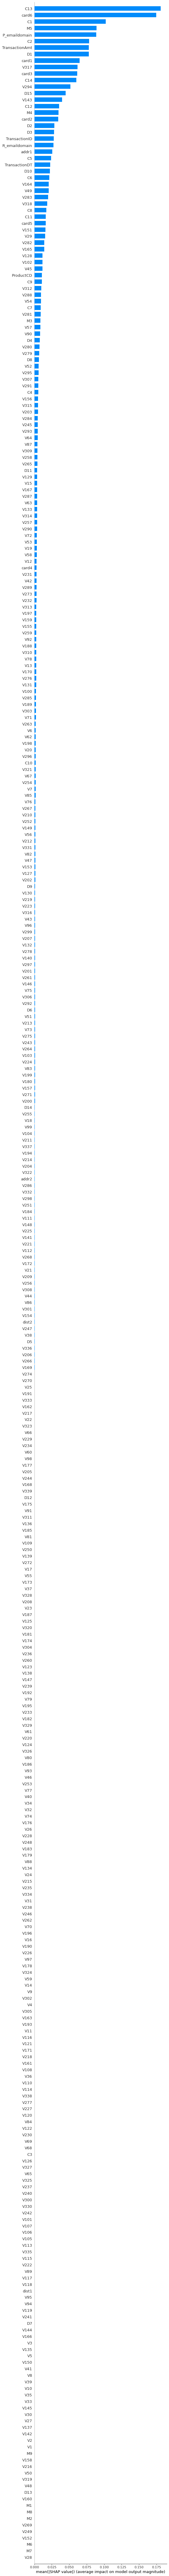

In [36]:
shap.summary_plot(shap_values, x_valid_, plot_type="bar", max_display=x_valid_.shape[1])

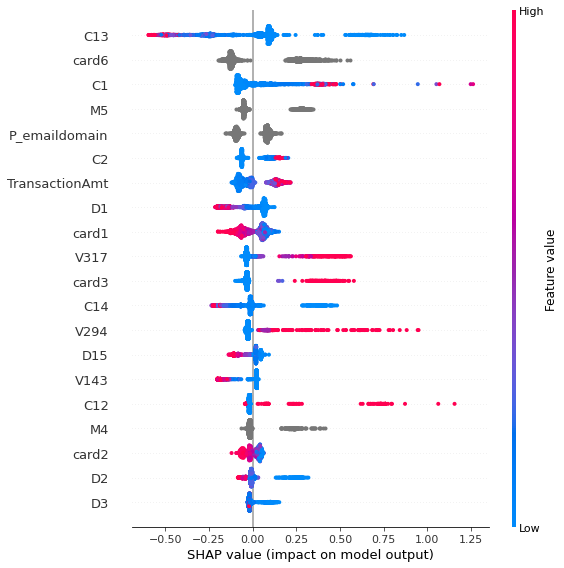

In [37]:
shap.summary_plot(shap_values, x_valid_)

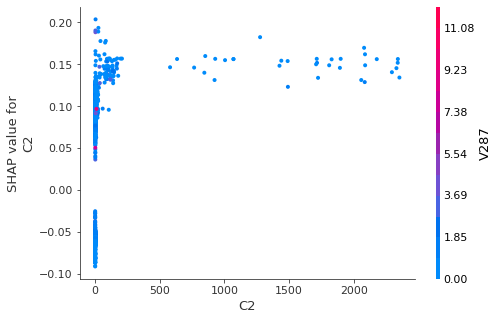

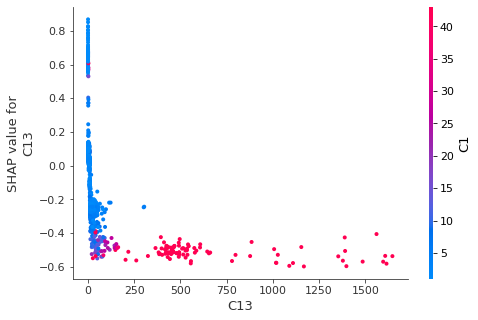

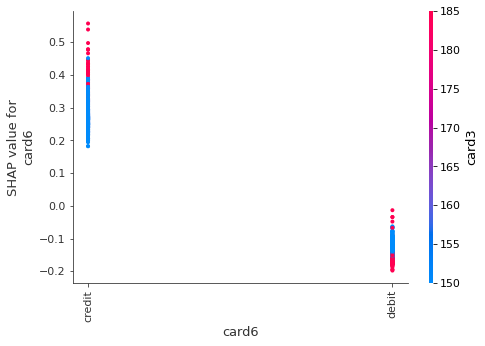

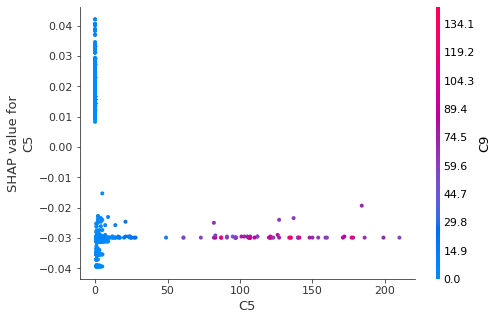

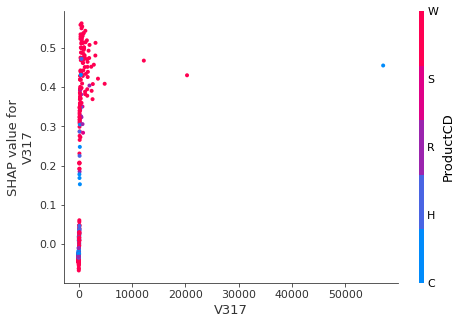

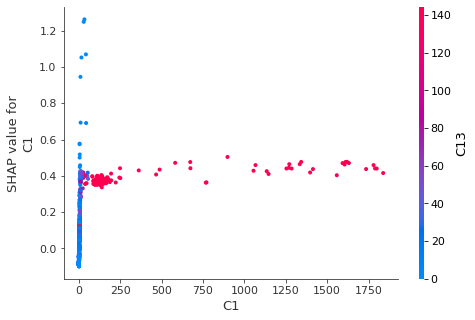

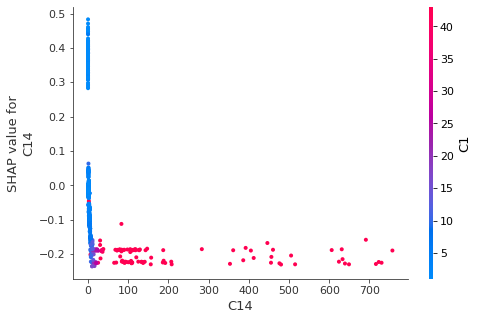

In [38]:
dependence_features = [
    "C2",
    "C13",
    "card6",
    "C5",
    "V317",
    "C1",
    "C14",
]
for name in dependence_features:
    shap.dependence_plot(name, shap_values, x_valid_, display_features=x_valid_)

In [39]:
pd.DataFrame({
    'name': x_valid_.columns,
    'importance': np.mean(np.abs(shap_values), axis=0)
}).sort_values(by='importance', ascending=False).reset_index(drop=True)

,name,importance
0,C13,0.180967
1,card6,0.174803
2,C1,0.102318
3,M5,0.088957
4,P_emaildomain,0.088848
...,...,...
388,V269,0.000000
389,V48,0.000000
390,V50,0.000000
391,V107,0.000000


In [40]:
features_no_imp = list(pd.DataFrame({'name': x_valid_.columns, 'importance': np.mean(np.abs(shap_values), axis=0)}
                              ).sort_values(by='importance', ascending=False).reset_index(drop=True).tail(200)['name'])
features_no_imp

['V172',
 'V21',
 'V209',
 'V256',
 'V308',
 'V44',
 'V86',
 'V301',
 'V154',
 'dist2',
 'V247',
 'V38',
 'D5',
 'V336',
 'V206',
 'V266',
 'V169',
 'V274',
 'V270',
 'V25',
 'V191',
 'V333',
 'V162',
 'V217',
 'V22',
 'V323',
 'V66',
 'V229',
 'V234',
 'V60',
 'V98',
 'V177',
 'V205',
 'V244',
 'V168',
 'V339',
 'D12',
 'V175',
 'V91',
 'V311',
 'V136',
 'V185',
 'V81',
 'V109',
 'V250',
 'V139',
 'V272',
 'V17',
 'V55',
 'V173',
 'V37',
 'V328',
 'V208',
 'V23',
 'V187',
 'V125',
 'V320',
 'V181',
 'V174',
 'V304',
 'V236',
 'V260',
 'V123',
 'V138',
 'V147',
 'V239',
 'V192',
 'V79',
 'V195',
 'V233',
 'V182',
 'V329',
 'V61',
 'V220',
 'V124',
 'V326',
 'V80',
 'V186',
 'V93',
 'V46',
 'V253',
 'V77',
 'V40',
 'V34',
 'V32',
 'V74',
 'V176',
 'V26',
 'V228',
 'V248',
 'V183',
 'V179',
 'V88',
 'V134',
 'V24',
 'V215',
 'V235',
 'V334',
 'V31',
 'V238',
 'V246',
 'V262',
 'V70',
 'V196',
 'V16',
 'V190',
 'V226',
 'V97',
 'V178',
 'V324',
 'V59',
 'V14',
 'V9',
 'V302',
 'V4',
 'V30

In [41]:
train_data_4 = train_data.drop(features_no_imp, axis = 'columns')
test_data_4 = test_data.drop(features_no_imp, axis = 'columns')
train_data_4.head(2)

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,P_emaildomain,R_emaildomain,C1,C2,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D6,D8,D9,D10,D11,D14,D15,M3,M4,M5,V6,V7,V12,V13,V15,V18,V19,V20,V29,V42,V43,V45,V47,V49,V51,V52,V53,V54,V56,V57,V58,V62,V63,V64,V67,V71,V72,V73,V75,V76,V78,V82,V83,V85,V87,V90,V92,V96,V99,V100,V102,V103,V104,V111,V112,V127,V128,V129,V130,V131,V132,V133,V140,V141,V143,V146,V148,V149,V151,V153,V155,V156,V157,V159,V164,V165,V167,V170,V180,V184,V188,V189,V194,V197,V198,V199,V200,V201,V202,V203,V204,V207,V210,V211,V212,V213,V214,V219,V221,V223,V224,V225,V231,V232,V243,V245,V251,V252,V254,V255,V257,V258,V259,V261,V263,V264,V265,V267,V268,V271,V273,V275,V276,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V303,V306,V307,V309,V310,V312,V313,V314,V315,V316,V317,V318,V321,V322,V331,V332,V337
0,2987000.0,86400.0,68.5,W,13926.0,369.0,150.0,discover,142.0,credit,315.0,87.0,gmail.com,gmail.com,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,106.0,13.0,32.0,0.0,66.875,0.666666,13.0,13.0,0.0,0.0,T,M2,F,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2987001.0,86401.0,29.0,W,2755.0,404.0,150.0,mastercard,102.0,credit,325.0,87.0,gmail.com,gmail.com,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,106.0,8.0,0.0,0.0,66.875,0.666666,0.0,30.0,0.0,0.0,T,M0,T,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
x_train, x_valid, y_train, y_valid = train_test_split(train_data_4, train_target, test_size=0.30)

cat = train_data_4.select_dtypes(include = ['object']).columns

cb_params = {
    "n_estimators": 600,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": 10,
    "max_depth": 6,
    "l2_leaf_reg": 100,
    "early_stopping_rounds": 50,
    "thread_count": 6,
    "random_seed": 42
}

model = cb.CatBoostClassifier(**cb_params)
model.fit(X = x_train, y = y_train, eval_set=[(x_valid, y_valid)], cat_features=cat)

# bestTest = 0.8816399332
# bestTest = 0.880192935 - изменение качества в третьей цифре
# bestTest = 0.8874828829
# bestTest = 0.8643861525 - изменение качества во второй цифре
# bestTest = 0.8772902947
# bestTest = 0.8823178529
# bestTest = 0.8763383913

0:	test: 0.6006306	best: 0.6006306 (0)	total: 69.3ms	remaining: 41.5s
10:	test: 0.7881170	best: 0.7881170 (10)	total: 788ms	remaining: 42.2s
20:	test: 0.8228868	best: 0.8231537 (19)	total: 1.61s	remaining: 44.3s
30:	test: 0.8320836	best: 0.8320836 (30)	total: 2.61s	remaining: 47.9s
40:	test: 0.8404086	best: 0.8406791 (38)	total: 3.46s	remaining: 47.2s
50:	test: 0.8456711	best: 0.8456711 (50)	total: 4.28s	remaining: 46.1s
60:	test: 0.8499619	best: 0.8506552 (56)	total: 5.27s	remaining: 46.5s
70:	test: 0.8536652	best: 0.8537515 (69)	total: 6.12s	remaining: 45.6s
80:	test: 0.8554867	best: 0.8554867 (80)	total: 7.14s	remaining: 45.8s
90:	test: 0.8577447	best: 0.8577447 (90)	total: 7.93s	remaining: 44.4s
100:	test: 0.8594958	best: 0.8594958 (100)	total: 8.71s	remaining: 43.1s
110:	test: 0.8597293	best: 0.8597510 (101)	total: 9.59s	remaining: 42.3s
120:	test: 0.8614012	best: 0.8614012 (120)	total: 10.3s	remaining: 40.8s
130:	test: 0.8626423	best: 0.8626423 (130)	total: 11.2s	remaining: 40.1s

In [43]:
train_score = roc_auc_score(y_train, model.predict(x_train, prediction_type = "Probability")[:,1])
valid_score = roc_auc_score(y_valid, model.predict(x_valid, prediction_type = "Probability")[:,1])
test_score = roc_auc_score(test_target, model.predict(test_data_4, prediction_type = "Probability")[:,1])

print(f"Train-score: {round(train_score, 3)}, Valid-score: {round(valid_score, 3)}, Test-score: {round(test_score, 3)}")

# Train-score: 0.89, Valid-score: 0.882, Test-score: 0.829
# Train-score: 0.9, Valid-score: 0.88, Test-score: 0.825  - изменение качества очень незначительное
# Train-score: 0.888, Valid-score: 0.864, Test-score: 0.817 - изменение качества во второй цифре
# Train-score: 0.896, Valid-score: 0.877, Test-score: 0.825
# Train-score: 0.901, Valid-score: 0.882, Test-score: 0.826
# Train-score: 0.892, Valid-score: 0.876, Test-score: 0.824

Train-score: 0.892, Valid-score: 0.876, Test-score: 0.824


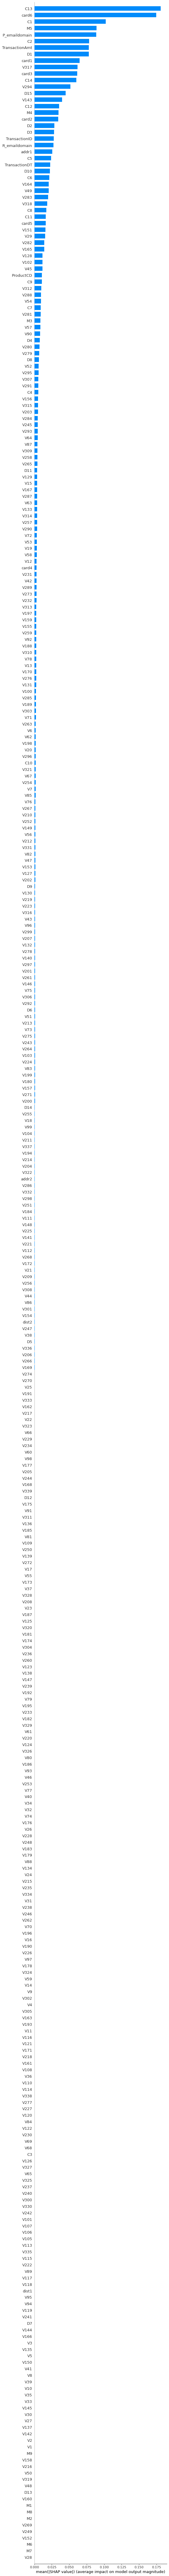

In [44]:
shap.summary_plot(shap_values, x_valid_, plot_type="bar", max_display=x_valid_.shape[1])

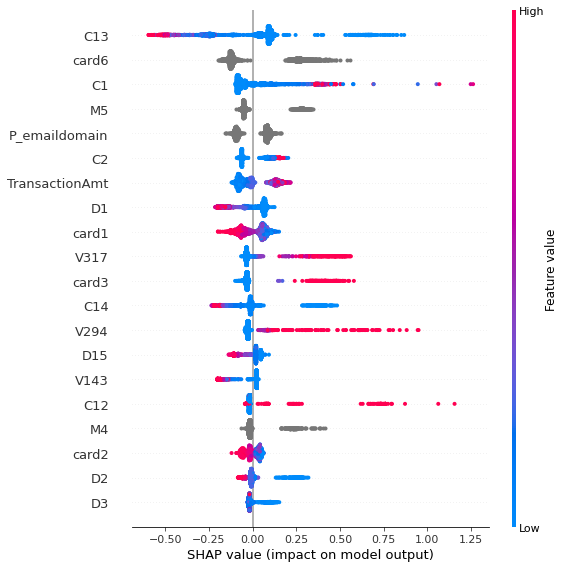

In [45]:
shap.summary_plot(shap_values, x_valid_)

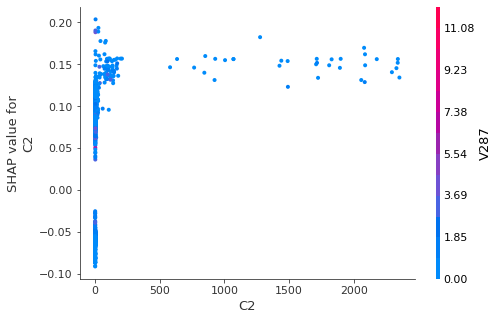

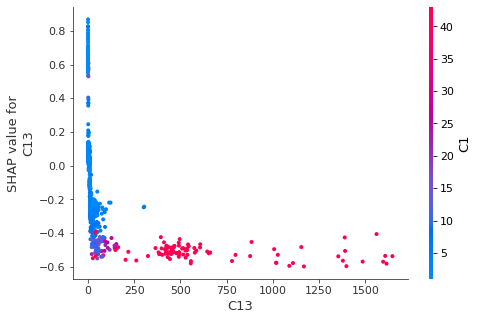

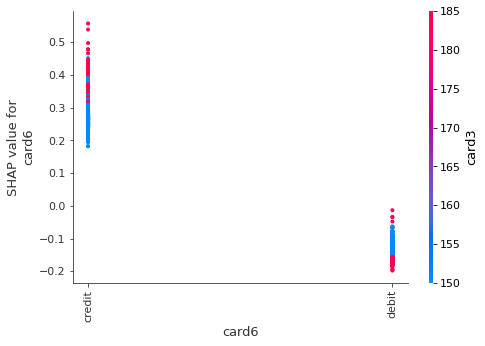

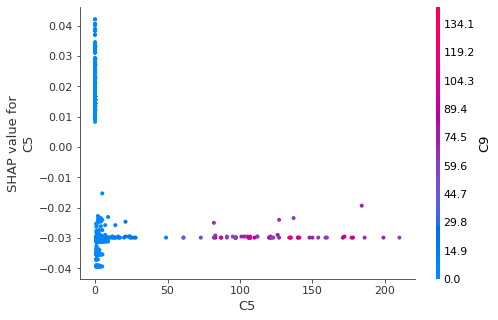

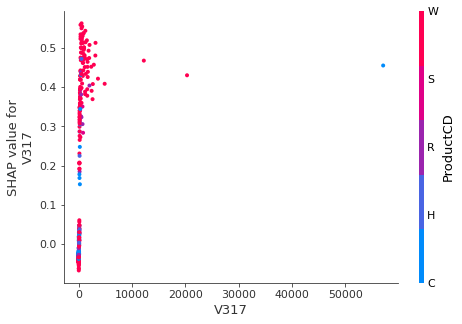

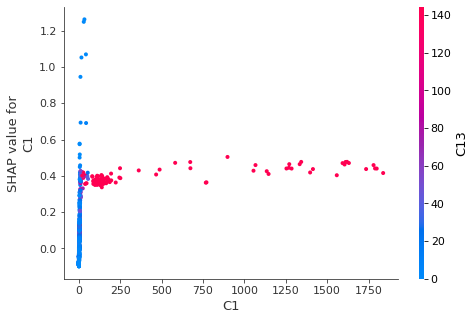

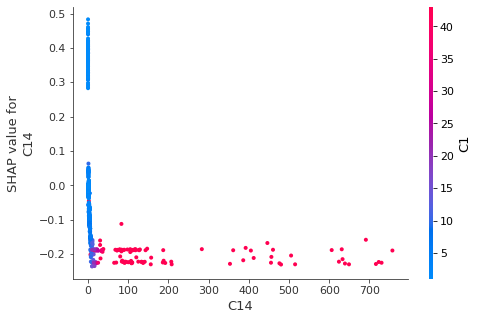

In [46]:
dependence_features = [
    "C2",
    "C13",
    "card6",
    "C5",
    "V317",
    "C1",
    "C14",
]
for name in dependence_features:
    shap.dependence_plot(name, shap_values, x_valid_, display_features=x_valid_)